This notebook is to select 10-20 stocks from a large number (may 100-200) of stocks

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
import yfinance as yf
from sklearn.preprocessing import StandardScaler

The stocks copy from the investors:

Pelosi:

'AAPL', 'GOOGL', 'MSFT', 'CRWD', 'TSLA', 'AB', 'AMZN', 'DIS'

GPT:

'SOFI', 'AMD', 'COCO', 'PLMR', 'BHVN', 'PSTG', 'CHWY', 'IIPR', 'NX', 'CCRN', 'GMS', 'MDB', 'INSE', 'GOOGLE', 'MSFT', 'FOUR', 'OLED', 'VEEV', 'DOCS', 'ABM'

INVERSE CRAMER:

'MSFT', 'WWE', 'RXD', 'AMZN', 'GOOGL', 'BITO', 'COIN', 'AAPD', 'REK', 'META', 'WRBY', 'GPS', 'BABA', 'SCO', 'BIRD'

BUFFET:

'AAPL', 'BAC', 'AXP', 'KO', 'CVX', 'OXY', 'KHC', 'MCO', 'ATVI', 'HPQ', 'DVA', 'VRSN', 'C', 'KR', 'GM'

BURRY:

'CI', 'NYCB', 'JD', 'BABA', 'BKI', 'COF', 'SIG', 'ZM', 'LILAK', 'SBSW', 'WFC', 'COHR', 'WAL', 'CTRA', 'REK'. 'GEO', 'DVN', 'NOV', 'PACW', 'HBAN'

CITADEL

'SH', 'TSLA', 'SJB', 'META', 'RWM', 'QQQ', 'AAPL', 'GLD', 'AMZN', 'TMUS', 'WMT', 'MSFT', 'BSX', 'JPM', 'V'

In [2]:
# Create stocks warehouse
stocks = [
    # Pelosi
    'AAPL', 'GOOGL', 'MSFT', 'TSLA', 'AB', 'AMZN', 'DIS',
    # GPT
    'AMD', 'PSTG', 'IIPR', 'NX', 'CCRN', 'GMS', 'MDB', 'INSE', 'OLED', 'VEEV', 'ABM',
    # Inverse Cramer
    'WWE', 'RXD', 'REK', 'META', 'GPS',
    # Buffet
    'BAC', 'AXP', 'KO', 'CVX', 'OXY', 'KHC', 'MCO', 'ATVI', 'HPQ', 'DVA', 'VRSN', 'C', 'KR', 'GM',
    # Burry
    'CI', 'NYCB', 'JD', 'BABA', 'BKI', 'COF', 'SIG', 'LILAK', 'SBSW', 'WFC', 'COHR', 'WAL', 'CTRA', 'GEO', 'DVN', 'NOV', 'HBAN',
    # Citadel
    'SJB', 'RWM', 'QQQ', 'TMUS', 'WMT', 'BSX', 'JPM', 'V',
    # Energy
    'XOM', 'MGY', 'PSX', 'EOG', 'MPC', 'COP',
    # Defense
    'LMT', 'BA', 'UTX.VI', 'GD', 'NOC', 'COL', 'TXT', 'AVAV', 'RTX', 'CAE',
    # Tech
    'INTC', 'TSM', 'QCOM', 'AVGO', 'CRUS', 'SNPS', 'ASML', 'MU', 'TXN', 'NVDA', 'STM', 'IBM', 'CSCO', 'T', 'GLW',
    'ORCL',
    # Utility
    'PG', 'MA', 'MRK', 'PEP', 'COST', 'PFE', 'MCD', 'TM', 'SHEL', 'NFLX', 'NKE', 'HSBC', 'VZ', 'UPS', 'HON',
    'SONY', 'SBUX', 'GS', 'MUFG', 'ADP', 'TD',
    # AI
    'ADSK'
]

# Read stock data from now to 5 years ago
end_date = pd.Timestamp.now()
start_date = end_date - pd.DateOffset(years=5)
prices = yf.download(stocks, start=start_date, end=end_date)['Adj Close'].dropna()
liquidity = yf.download(stocks, start=start_date, end=end_date)['Volume'].dropna()

[*********************100%***********************]  116 of 116 completed
[*********************100%***********************]  116 of 116 completed


'AAPD', 'BHVN', 'BIRD', 'BITO', 'CHWY', 'COCO', 'COIN', 'CRWD', 'DOCS', 'FOUR', 'PLMR', 'SOFI', 'WRBY', 'ZM'
These stocks has no 5 years history, discarded.

(CVXPY) Jun 10 06:39:03 PM: Encountered unexpected exception importing solver CVXOPT:
ImportError('DLL load failed while importing base: 找不到指定的模块。')
(CVXPY) Jun 10 06:39:03 PM: Encountered unexpected exception importing solver GLPK:
ImportError('DLL load failed while importing base: 找不到指定的模块。')
(CVXPY) Jun 10 06:39:03 PM: Encountered unexpected exception importing solver GLPK_MI:
ImportError('DLL load failed while importing base: 找不到指定的模块。')


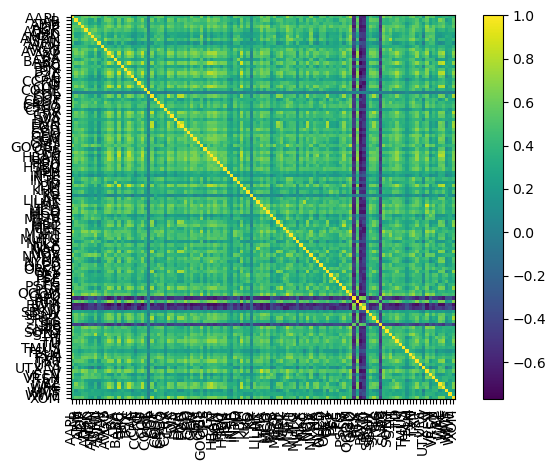

In [3]:
import pypfopt
from pypfopt import risk_models
from pypfopt import plotting

sample_cov = risk_models.sample_cov(prices, frequency=252)
# Ledoit-Wolf shrinkage
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
plotting.plot_covariance(S, plot_correlation=True);


In [4]:
from pypfopt import expected_returns

mu = expected_returns.capm_return(prices)
mu

AAPL    0.158118
AB      0.192130
ABM     0.170164
ADP     0.157887
ADSK    0.180430
          ...   
WAL     0.228817
WFC     0.193407
WMT     0.074701
WWE     0.136278
XOM     0.171310
Name: mkt, Length: 116, dtype: float64

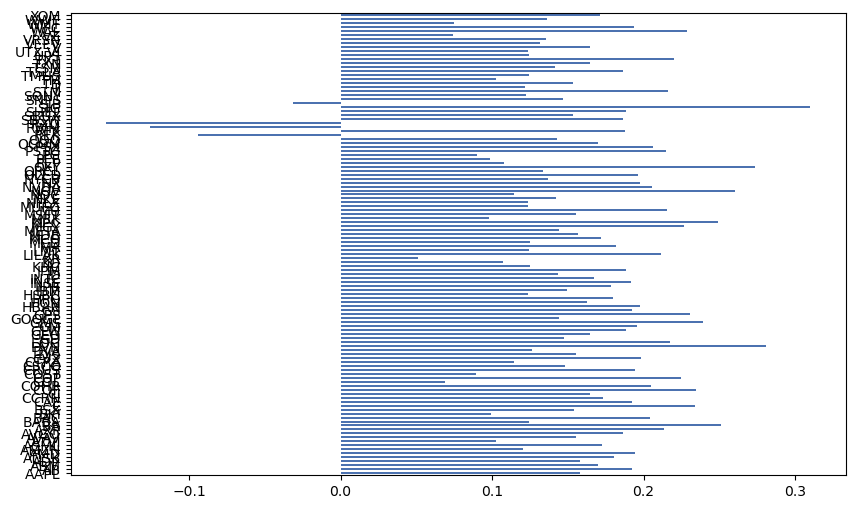

In [5]:
mu.plot.barh(figsize=(10,6));


In [11]:
from pypfopt import EfficientFrontier
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

# You don't have to provide expected returns in this case
ef = EfficientFrontier(None, S, weight_bounds=(None, None))
ef.min_volatility()
weights = ef.clean_weights()
weights

collections.OrderedDict

In [17]:
weights = dict(weights)
sorted_d = sorted(weights.items(), key=lambda x: x[1], reverse=True)

# 打印出值最大的前15个键值对
temp = dict(sorted_d[:15])

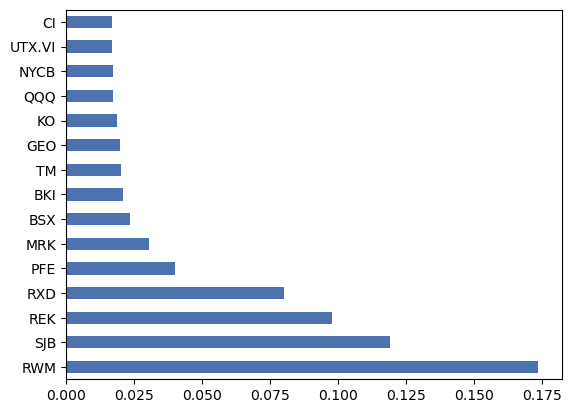

In [18]:
pd.Series(temp).plot.barh();

In [19]:
ef.portfolio_performance(verbose=True);

Annual volatility: 3.7%


In [114]:
df_transposed = prices.transpose()
scaler_price  = StandardScaler()
scaled_price_data  = scaler_price .fit_transform(df_transposed)

df_liquidity_transposed = liquidity.transpose()
scaler_liquidity = StandardScaler()
scaled_liquidity_data = scaler_liquidity.fit_transform(df_liquidity_transposed)

# 进行聚类，这里假设我们分为10类
kmeans = KMeans(n_clusters=20, random_state=0)
clusters = kmeans.fit_predict(scaled_price_data)

# 创建一个新的DataFrame，包含股票和对应的类别
df_clustered = pd.DataFrame()
df_clustered['stock'] = prices.columns
df_clustered['cluster'] = clusters

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(


In [115]:
# 建立随机森林模型
rf_price = RandomForestRegressor(n_estimators=100, random_state=0)
rf_liquidity = RandomForestRegressor(n_estimators=100, random_state=0)

best_stocks = []

# 对每个聚类进行处理
for cluster in set(clusters):
    stocks_in_cluster = df_clustered[df_clustered['cluster'] == cluster]['stock']

    best_score = -np.inf
    best_stock = None

    # 对每个聚类中的股票进行评价
    for stock in stocks_in_cluster:
        # 我们使用随机森林对股票的价格进行预测，然后通过比较真实价格和预测价格的相似度来评价股票
        X = prices[stock][:-1]
        y = prices[stock][1:]
        X_liquidity = liquidity[stock][:-1]
        y_liquidity = liquidity[stock][1:]

        rf_price.fit(X.values.reshape(-1, 1), y)
        score_price = rf_price.score(X.values.reshape(-1, 1), y)

        rf_liquidity.fit(X_liquidity.values.reshape(-1, 1), y_liquidity)
        score_liquidity = rf_liquidity.score(X_liquidity.values.reshape(-1, 1), y_liquidity)

        score = (score_price + 0.05 * score_liquidity) / 1.05
        print(stock)
        print(score)

        # 如果这个股票的评价比之前的都好，那么我们就选择这个股票
        if score > best_score:
            best_score = score
            best_stock = stock

    best_stocks.append(best_stock)

print(best_stocks)

AB
0.9851593550998075
CAE
0.9914124767074075
CCRN
0.9749152405932117
COL
0.9212312729011278
CTRA
0.9900183304869468
DVN
0.9929549548967331
GEO
0.9903445333610859
GMS
0.9836773113849913
GPS
0.9897747135991085
HBAN
0.9878842865393396
HPQ
0.9813476631986071
INSE
0.9811137001679192
LILAK
0.9881928898031409
MGY
0.9890932968988219
MUFG
0.9865322701316547
NX
0.9810036916325509
NYCB
0.9818122824510758
PSTG
0.9821741715018013
SBSW
0.9885030407184346
SJB
0.9894771582133061
STM
0.9899903560823369
T
0.987210145759987
AVGO
0.9891986500345032
COST
0.993754821642889
MA
0.992503820629653
AMZN
0.9931057560995583
NKE
0.9905762135940133
PEP
0.9887361290640587
PG
0.992111987260495
TXN
0.9890939426280809
UPS
0.9906281591985934
WMT
0.9908036351513977
C
0.9912285599007854
COP
0.993035763741899
CSCO
0.9848850747215048
INTC
0.9808199286915804
KO
0.986448546930775
MPC
0.9908101987362467
MU
0.9833832002829238
ORCL
0.9872379622180288
OXY
0.9974409517180747
RXD
0.9695994646269921
SHEL
0.9955196059353778
TD
0.98973

[*********************100%***********************]  20 of 20 completed


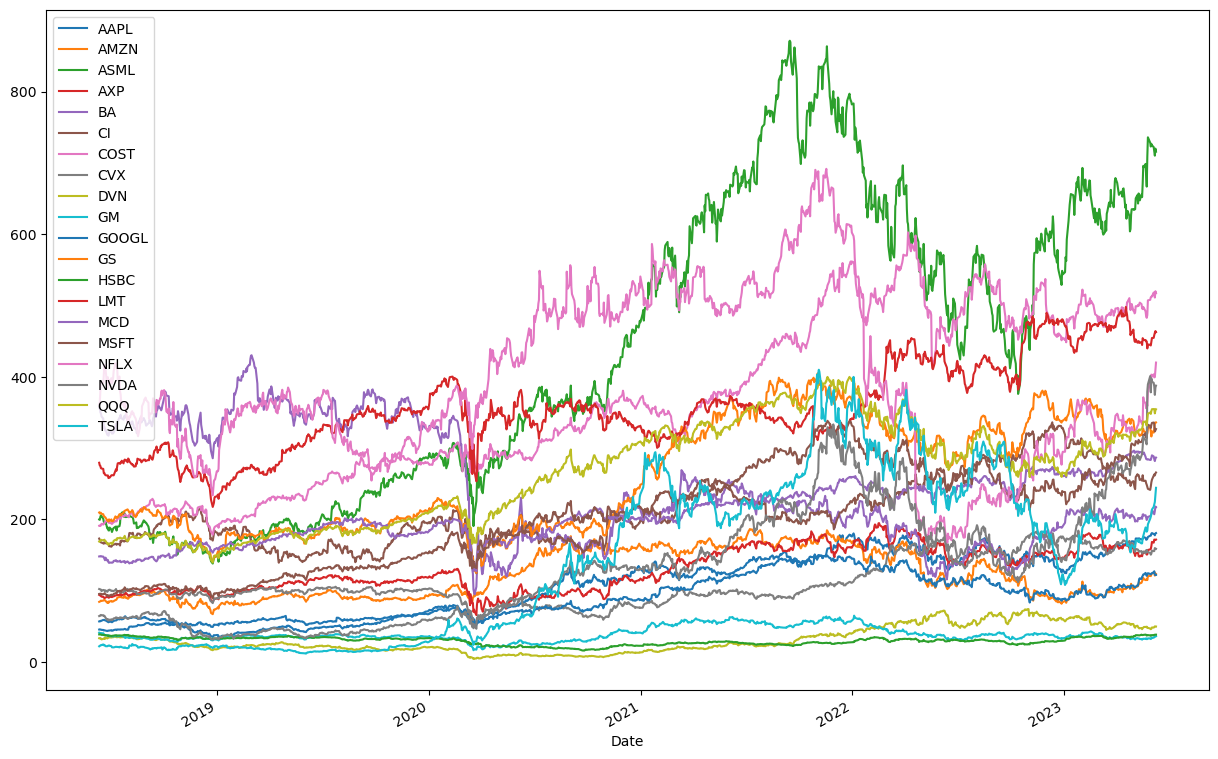

In [118]:
# Read stock data from now to 5 years ago
best_stocks = ['DVN', 'COST', 'AMZN', 'GOOGL', 'GM', 'NFLX', 'TSLA', 'LMT', 'BA', 'HSBC', 'MSFT', 'QQQ', 'CVX', 'AXP', 'NVDA', 'MCD', 'AAPL', 'GS', 'ASML', 'CI']
end_date = pd.Timestamp.now()
start_date = end_date - pd.DateOffset(years=5)
prices = yf.download(best_stocks, start=start_date, end=end_date)['Adj Close']
prices[prices.index >= "2008-01-01"].plot(figsize=(15,10));

In [ ]:
def getBestStock():
    return ['PFE', 'COST', 'AMZN', 'GOOGL', 'MRK', 'NFLX', 'TSLA', 'LMT', 'BSX', 'HSBC', 'MSFT', 'QQQ', 'CVX', 'AXP', 'NVDA', 'MCD', 'AAPL', 'GS', 'ASML', 'CI']
['PFE', 'COST', 'AMZN', 'GOOGL', 'MRK', 'TSLA', 'LMT', 'BSX', 'HSBC', 'MSFT', 'QQQ', 'CVX', 'MCD', 'AAPL', 'GS', 'CI']

Final version:
['DVN', 'COST', 'AMZN', 'GOOGL', 'GM', 'NFLX', 'TSLA', 'LMT', 'BA', 'HSBC', 'MSFT', 'QQQ', 'CVX', 'AXP', 'NVDA', 'MCD', 'AAPL', 'GS', 'ASML', 'CI']
DVN: 德文能源
COST: costco
AMZN: Amazon
GOOGL: Google
GM: 通用汽车
NFLX: Netflix
TSLA: Tesla
LMT: 洛克希德马丁
BA: Boeing
HSBC: HSBC
MSFT: Microsoft
QQQ: QQQ信托
CVX: 雪佛龙(石油天然气)
AXP: American Express
NVDA: Nvidia
MCD: McDonald's
AAPL: Apple
GS: Goldman Sachs
ASML: ASML
CI: Cigna(信诺医疗保健)